<a href="https://colab.research.google.com/github/nine-point-eight-p/deepul/blob/master/homeworks/hw1/hw1_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an autoregressive model and run it on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [70]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git
!unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 758, done.
remote: Total 758 (delta 0), reused 0 (delta 0), pack-reused 758
Receiving objects: 100% (758/758), 118.40 MiB | 5.49 MiB/s, done.
Resolving deltas: 100% (347/347), done.
Updating files: 100% (129/129), done.
Processing ./deepul
  Preparing metadata (setup.py) ... done
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=16618 sha256=791e69c65aeef3541abd4cba868de3dd1f85a26f53f5043362a2b5e84db0edc7
  Stored in directory: /tmp/pip-ephem-wheel-cache-ft5f1eox/wheels/89/4d/b7/d666c1fdc2a51554c762f2cfe90dad1098871e7fea5c53eed4
Successfully built deepul
  Attempting uninstall: deepul
    Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0


In [71]:
from deepul.hw1_helper import *

In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as distributions

from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


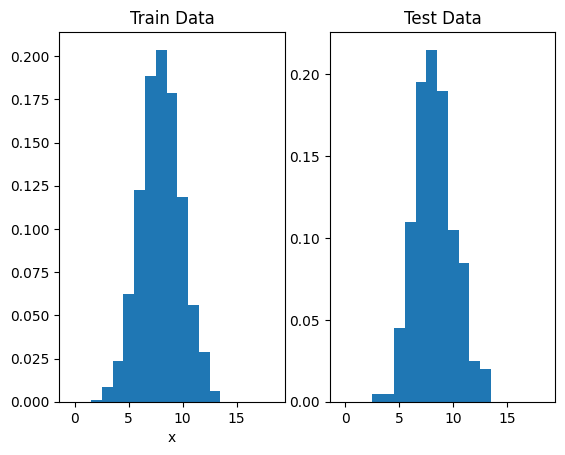

Dataset 2


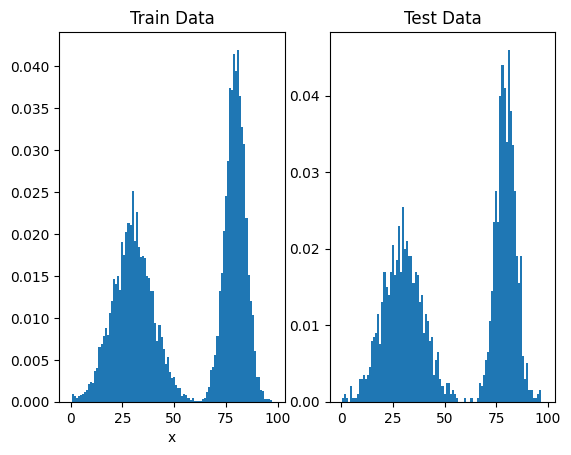

In [ ]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{d-1}) \in \mathbb{R}^d$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,d-1\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [73]:
def train(model, data_loader, criterion, optimizer):
  model.train()
  train_losses = []
  for data in data_loader:
    # 1) Use total distribution as target (processed in single batch)
    # target = get_dist(data.cuda(), model.d)
    # All of these working??
    # loss = criterion(model().cuda(), target)
    # loss = criterion(model.logits, target)
    # loss = model.loss(target)
    # 2) Use class indices (processed in multiple batches)
    loss = model.loss(data.to(device))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
  return train_losses

def test(model, data_loader, criterion):
  model.eval()
  with torch.no_grad():
    total_loss = 0
    # output = model().cuda()
    for data in data_loader:
      # 1) Use total distribution as target (processed in single batch)
      # target = get_dist(data.cuda(), model.d)
      # All of these working?
      # loss = criterion(model().cuda(), target)
      # loss = criterion(model.logits, target)
      # loss = model.loss(target)
      # 2) Use class indices (processed in multiple batches)
      loss = model.loss(data.to(device))
      total_loss += loss * len(data)

  avg_loss = total_loss / len(data_loader.dataset)
  return avg_loss.item()

def train_epochs(model, train_loader, test_loader, hyper):
  num_epochs, learning_rate = hyper['num_epochs'], hyper['learning_rate']
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  criterion = nn.CrossEntropyLoss()

  train_losses = []
  test_losses = []

  for epoch in range(num_epochs):
    train_losses.extend(train(model, train_loader, criterion, optimizer))
    test_loss = test(model, test_loader, criterion)
    test_losses.append(test_loss)
    print(f'Epoch {epoch}, test loss: {test_loss}')

  return train_losses, test_losses

In [ ]:
class HistogramFitter(nn.Module):
  def __init__(self, d):
    super().__init__()
    self.d = d
    self.logits = nn.Parameter(torch.zeros(d))

  def forward(self):
    return F.softmax(self.logits, dim=0)

  def loss(self, target):
    # Use UNORMALIZED logits
    # Size: logits (N, C), target (N)
    logits = self.logits.repeat(target.shape[0], 1)
    return F.cross_entropy(logits, target.long())

  def get_distribution(self):
    dist = F.softmax(self.logits, dim=0)
    return dist.cpu().detach().numpy()

def get_dist(data, size=0):
  if not isinstance(data, torch.Tensor):
    data = torch.tensor(data)
  return torch.bincount(data, minlength=size) / len(data)

In [ ]:
def q1_a(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
              used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """

  """ YOUR CODE HERE """
  hyper = {
    1: {
      "num_epochs": 50,
      "batch_size": 128,
      "learning_rate": 0.1
    },
    2: {
      "num_epochs": 20,
      "batch_size": 128,
      "learning_rate": 0.003,
    },
  }

  model = HistogramFitter(d).to(device)

  train_loader = DataLoader(
    train_data,
    # batch_size=len(train_data), # for single batch
    batch_size=hyper[dset_id]["batch_size"],
    shuffle=True,
  )
  test_loader = DataLoader(
    test_data,
    # batch_size=len(test_data), # for single batch
    batch_size=hyper[dset_id]["batch_size"],
  )

  train_losses, test_losses = train_epochs(model, train_loader, test_loader, hyper[dset_id])

  # KL divergence between ground truth and model
  true_dist = distributions.Categorical(get_dist(test_data, d).cuda())
  model_dist = distributions.Categorical(model())
  kl_div = distributions.kl.kl_divergence(true_dist, model_dist)
  print(f'KL divergence: {kl_div.item()}')

  return np.array(train_losses), np.array(test_losses), model.get_distribution()


### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



Epoch 0, test loss: 2.4083304405212402
Epoch 1, test loss: 2.170485258102417
Epoch 2, test loss: 2.096872568130493
Epoch 3, test loss: 2.0804269313812256
Epoch 4, test loss: 2.074568033218384
Epoch 5, test loss: 2.075485944747925
Epoch 6, test loss: 2.080186605453491
Epoch 7, test loss: 2.0736207962036133
Epoch 8, test loss: 2.0654287338256836
Epoch 9, test loss: 2.061599016189575
Epoch 10, test loss: 2.060807704925537
Epoch 11, test loss: 2.0630242824554443
Epoch 12, test loss: 2.0631003379821777
Epoch 13, test loss: 2.0619170665740967
Epoch 14, test loss: 2.0603063106536865
Epoch 15, test loss: 2.0586190223693848
Epoch 16, test loss: 2.0590741634368896
Epoch 17, test loss: 2.0568690299987793
Epoch 18, test loss: 2.0551810264587402
Epoch 19, test loss: 2.057950496673584
Epoch 20, test loss: 2.0584542751312256
Epoch 21, test loss: 2.0557146072387695
Epoch 22, test loss: 2.0546774864196777
Epoch 23, test loss: 2.051914691925049
Epoch 24, test loss: 2.058028221130371
Epoch 25, test loss:

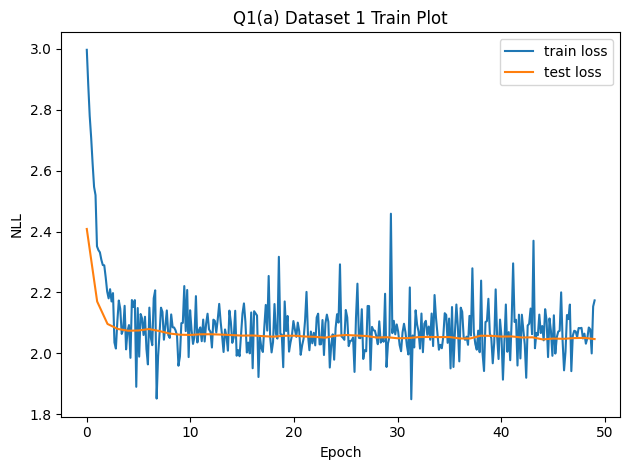

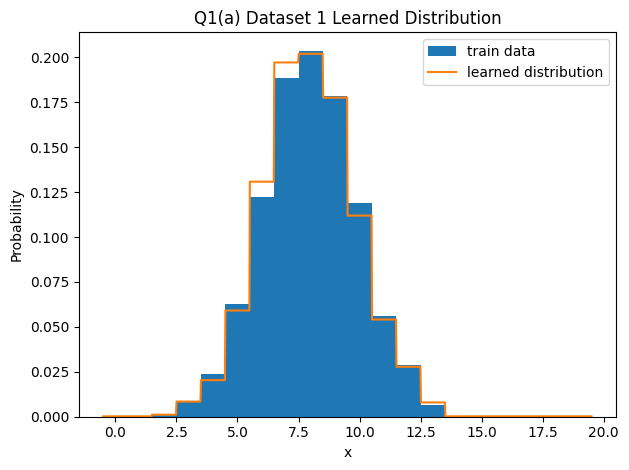

In [ ]:
q1_save_results(1, 'a', q1_a)

Epoch 0, test loss: 4.4822845458984375
Epoch 1, test loss: 4.38472318649292
Epoch 2, test loss: 4.307988166809082
Epoch 3, test loss: 4.248375415802002
Epoch 4, test loss: 4.201952934265137
Epoch 5, test loss: 4.1663055419921875
Epoch 6, test loss: 4.139415264129639
Epoch 7, test loss: 4.118464469909668
Epoch 8, test loss: 4.102242469787598
Epoch 9, test loss: 4.09000301361084
Epoch 10, test loss: 4.080320835113525
Epoch 11, test loss: 4.07281494140625
Epoch 12, test loss: 4.066717624664307
Epoch 13, test loss: 4.0618743896484375
Epoch 14, test loss: 4.057920455932617
Epoch 15, test loss: 4.054532051086426
Epoch 16, test loss: 4.051776885986328
Epoch 17, test loss: 4.049521446228027
Epoch 18, test loss: 4.0477471351623535
Epoch 19, test loss: 4.046008110046387
KL divergence: 0.037981949746608734
Final Test Loss: 4.0460


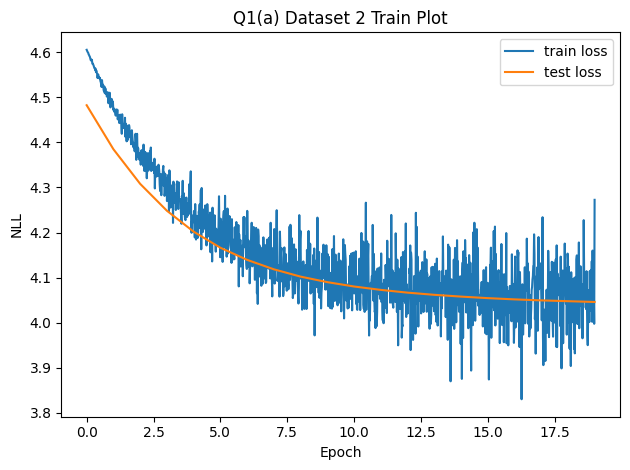

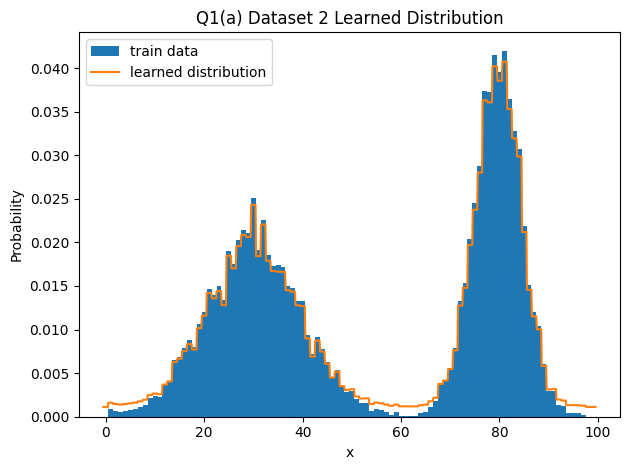

In [ ]:
q1_save_results(2, 'a', q1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = d-1$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
class LogisticMixtureFitter(nn.Module):
  def __init__(self, d, num_mix=4):
    super().__init__()
    self.d = d
    self.num_mix = num_mix
    self.weights = nn.Parameter(torch.zeros(num_mix)) # need normalization with softmax before using
    self.means = nn.Parameter(torch.arange(num_mix).float() / (num_mix - 1) * d)
    self.log_scales = nn.Parameter(torch.randn(num_mix)) # use exp(log_s) to prevent negative

  def forward(self, x):
    # Naive implementation
    # inv_scales = torch.exp(-self.log_scales + 1e-6)

    # plus = x + 0.5
    # plus[-1] = float('inf')
    # plus = plus.unsqueeze(1).repeat(1, self.num_mix)
    # plus = (plus - self.means) * inv_scales

    # minus = x - 0.5
    # minus[0] = float('-inf')
    # minus = minus.unsqueeze(1).repeat(1, self.num_mix)
    # minus = (minus - self.means) * inv_scales

    # result = F.softmax(self.weights) * (F.sigmoid(plus) - F.sigmoid(minus))
    # return torch.log(torch.sum(result, dim=1))

    # Implementation based on original paper and solution
    # Ref: https://github.com/openai/pixel-cnn/blob/master/pixel_cnn_pp/nn.py#L46
    x = x.unsqueeze(1).repeat(1, self.num_mix) # [batch_size, num_mix]

    centered_x = x - self.means
    inv_scales = torch.exp(-self.log_scales) # (original scales)^(-1)
    plus_in = inv_scales * (centered_x + 0.5)
    min_in = inv_scales * (centered_x - 0.5)

    cdf_plus = torch.sigmoid(plus_in)
    cdf_min = torch.sigmoid(min_in)
    cdf_delta = cdf_plus - cdf_min

    # log_cdf_plus = plus_in - F.softplus(plus_in) # log probability for edge case of 0 (before scaling)
    # log_one_minus_cdf_min = -F.softplus(min_in) # log probability for edge case of 255 (before scaling)

    # log probability for edge case of 0 (0 + 0.5)
    log_cdf_plus = torch.log(torch.clamp(torch.sigmoid(inv_scales * (0.5 - self.means)), min=1e-12))
    # log probability for edge case of d-1 (d - 1 - 0.5)
    log_one_minus_cdf_min = torch.log(torch.clamp(1 - torch.sigmoid(inv_scales * (self.d - 1.5 - self.means)), min=1e-12))
    # log probability for all other cases
    log_cdf_delta = torch.log(torch.clamp(cdf_delta, min=1e-12))

    x_log_probs = torch.where(x < 1e-3, log_cdf_plus,
                              torch.where(x > self.d - 1 - 1e-3, log_one_minus_cdf_min, log_cdf_delta))
    pi_log_probs = F.log_softmax(self.weights, dim=0) # log NORMALIZED weights
    log_probs = pi_log_probs + x_log_probs

    return torch.logsumexp(log_probs, dim=1) # log probability

  def loss(self, target):
    return -torch.mean(self(target)) # mean of NLL

  def get_distribution(self):
    with torch.no_grad():
      dist = self(torch.arange(self.d).to(device)).exp()
    return dist.cpu().detach().numpy()


In [ ]:
def q1_b(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """

  """ YOUR CODE HERE """
  hyper = {
    1: {
      "num_epochs": 20,
      "batch_size": 128,
      "learning_rate": 0.05
    },
    2: {
      "num_epochs": 20,
      "batch_size": 128,
      "learning_rate": 0.05,
    },
  }

  model = LogisticMixtureFitter(d).to(device)

  train_loader = DataLoader(
    train_data,
    batch_size=hyper[dset_id]["batch_size"],
    shuffle=True,
  )
  test_loader = DataLoader(
    test_data,
    batch_size=hyper[dset_id]["batch_size"],
  )

  train_losses, test_losses = train_epochs(model, train_loader, test_loader, hyper[dset_id])

  return np.array(train_losses), np.array(test_losses), model.get_distribution()


### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



Epoch 0, test loss: 2.7625505924224854
Epoch 1, test loss: 2.4362993240356445
Epoch 2, test loss: 2.261298894882202
Epoch 3, test loss: 2.1746985912323
Epoch 4, test loss: 2.1339290142059326
Epoch 5, test loss: 2.108769416809082
Epoch 6, test loss: 2.0943427085876465
Epoch 7, test loss: 2.0903918743133545
Epoch 8, test loss: 2.0923256874084473
Epoch 9, test loss: 2.0839531421661377
Epoch 10, test loss: 2.0794529914855957
Epoch 11, test loss: 2.074080467224121
Epoch 12, test loss: 2.073213815689087
Epoch 13, test loss: 2.069760799407959
Epoch 14, test loss: 2.0682711601257324
Epoch 15, test loss: 2.0699281692504883
Epoch 16, test loss: 2.0700650215148926
Epoch 17, test loss: 2.0745737552642822
Epoch 18, test loss: 2.07387638092041
Epoch 19, test loss: 2.0655322074890137
Final Test Loss: 2.0655


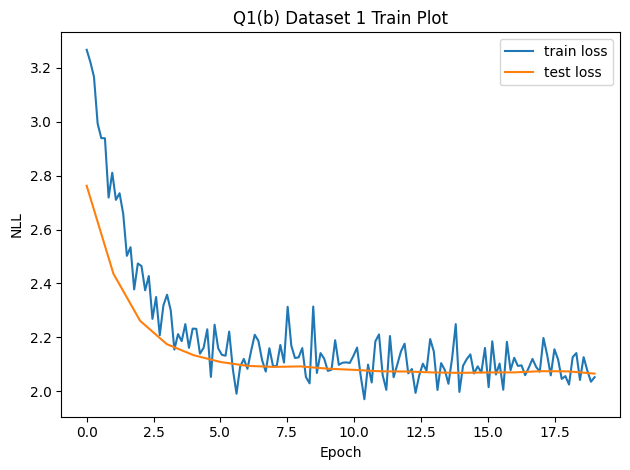

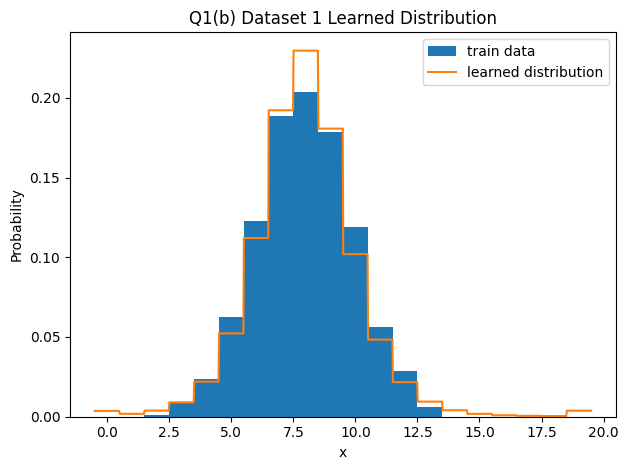

In [ ]:
q1_save_results(1, 'b', q1_b)

Epoch 0, test loss: 4.479773044586182
Epoch 1, test loss: 4.38340425491333
Epoch 2, test loss: 4.214969158172607
Epoch 3, test loss: 4.055578231811523
Epoch 4, test loss: 4.0413713455200195
Epoch 5, test loss: 4.041006088256836
Epoch 6, test loss: 4.039810657501221
Epoch 7, test loss: 4.0390167236328125
Epoch 8, test loss: 4.0389862060546875
Epoch 9, test loss: 4.041612148284912
Epoch 10, test loss: 4.04057502746582
Epoch 11, test loss: 4.039036273956299
Epoch 12, test loss: 4.040541172027588
Epoch 13, test loss: 4.0402302742004395
Epoch 14, test loss: 4.04163932800293
Epoch 15, test loss: 4.042863845825195
Epoch 16, test loss: 4.042051315307617
Epoch 17, test loss: 4.0390801429748535
Epoch 18, test loss: 4.042440414428711
Epoch 19, test loss: 4.039645195007324
Final Test Loss: 4.0396


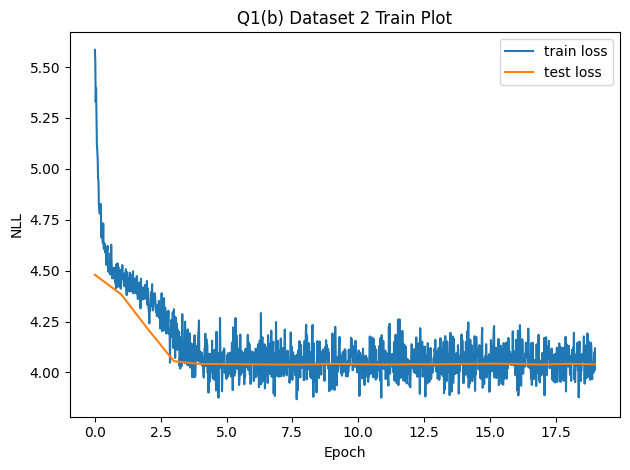

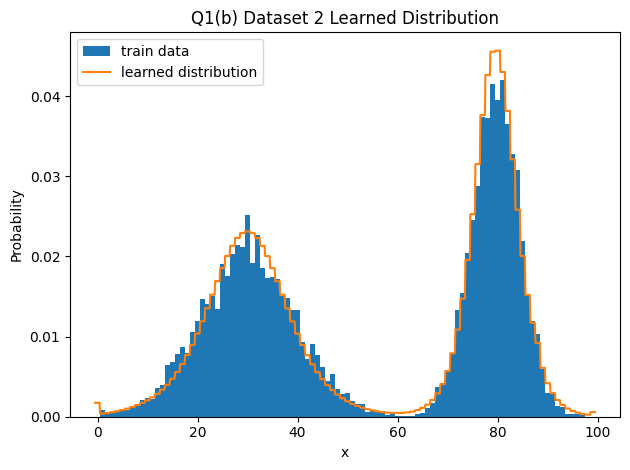

In [ ]:
q1_save_results(2, 'b', q1_b)

# Question 2: MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (a) Fitting 2D Data

First, you will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, d\}$. We can easily visualize a 2D dataset by plotting a 2D histogram. Run the cell below to visualize our datasets.

Dataset 1


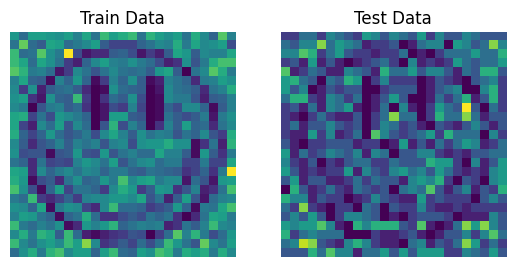

Dataset 2


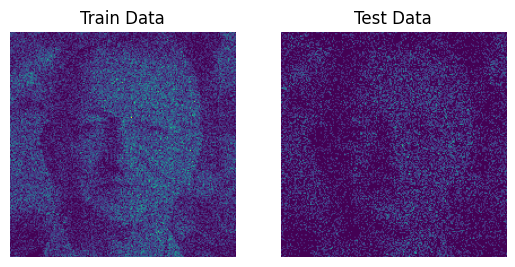

In [ ]:
visualize_q2a_data(dset_type=1)
visualize_q2a_data(dset_type=2)

Implement and train a MADE model through maximum likelihood to represent $p(x_0, x_1)$ on the given datasets, with any autoregressive ordering of your choosing.

A few notes:
* You do not need to do training with multiple masks
* You made find it useful to one-hot encode your inputs.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. Visualize the learned 2D distribution by plotting a 2D heatmap


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
# Somehow works
class HistogramFitter2D(nn.Module):
  def __init__(self, d):
    super().__init__()
    self.d = d
    self.logits = nn.Parameter(torch.zeros(d * d))

  def forward(self):
    return F.softmax(self.logits, dim=0)

  def loss(self, target):
    logits = self.logits.repeat(target.shape[0], 1)
    target = target[:, 0] * self.d + target[:, 1]
    return F.cross_entropy(logits, target)

  def get_distribution(self):
    with torch.no_grad():
      dist = self().view(self.d, self.d)
    return dist.cpu().detach().numpy()


In [ ]:
import operator

class MaskedLinear(nn.Linear):
  def __init__(self, in_features, out_features, mask, bias=True):
    super().__init__(in_features, out_features, bias)
    self.register_buffer('mask', mask)

  def forward(self, x):
    return F.linear(x, self.weight * self.mask, self.bias)

class MADE(nn.Module):
  def __init__(self, num_features, d, hidden_size=(512, 512, 512)):
    super().__init__()
    self.d = d
    self.num_features = num_features

    # mask_init = torch.randperm(num_features) + 1 # Order-agnostic
    mask_init = torch.arange(1, num_features + 1)
    mask_vecs = [mask_init]
    for size in hidden_size:
      vec = torch.randint(mask_vecs[-1].min(), num_features, (size,))
      mask_vecs.append(vec)
    mask_vecs.append(mask_init)

    layers = []
    for last_mask_vec, mask_vec in zip(mask_vecs[:-2], mask_vecs[1:-1]):
      mask = MADE.create_mask(last_mask_vec, mask_vec)
      layers.append(MaskedLinear(len(last_mask_vec), len(mask_vec), mask))
      layers.append(nn.ReLU())
    mask = MADE.create_mask(mask_vecs[-2], mask_vecs[-1], comp='>')
    layers.append(MaskedLinear(len(mask_vecs[-2]), len(mask_vecs[-1]), mask)) # To output layer
    layers.append(nn.Sigmoid())

    assert len(layers) == 2 * (len(hidden_size) + 1) # Including output layer
    self.layers = nn.Sequential(*layers)

  @staticmethod
  def create_mask(last_mask_vec, mask_vec, comp='>='):
    comparison = {
      '>': operator.gt,
      '>=': operator.ge,
    }
    assert comp in comparison.keys(), f"Operator '{comp}' not supported"
    mask = comparison[comp](mask_vec.unsqueeze(1), last_mask_vec)
    return mask.float()

  def forward(self, x):
    return self.layers(x)

  def loss(self, target):
    return F.cross_entropy(self(target), target)

  def get_distribution(self):
    with torch.no_grad():
      target = torch.eye(self.num_features).to(device) # one-hot input
      output = self(target)
      nll = F.cross_entropy(output, target, reduction='none')
      dist = F.softmax(torch.exp(-nll))
    return dist.view(self.d, self.d).cpu().detach().numpy()


In [ ]:
def q2_a(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for each random variable x1 and x2
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d, d) of probabilities (the learned joint distribution)
  """

  """ YOUR CODE HERE """
  hyper = {
    1: {
      "num_epochs": 20,
      "batch_size": 128,
      "learning_rate": 0.01,
    },
    2: {
      "num_epochs": 10,
      "batch_size": 128,
      "learning_rate": 0.001,
    },
  }

  model = MADE(d * d, d).to(device)

  def one_hot_collate(coords):
    # PyTorch warning: extremely slow when converting a list of np.array,
    # so convert to np.ndarray first
    coords = torch.tensor(np.array(coords))
    labels = coords[:, 0] * d + coords[:, 1]
    one_hot = torch.zeros(labels.shape[0], d * d)
    one_hot.scatter_(1, labels.unsqueeze(1), 1)
    return one_hot

  train_loader = DataLoader(
    train_data,
    # batch_size=len(train_data), # for single batch
    batch_size=hyper[dset_id]["batch_size"],
    shuffle=True,
    collate_fn=one_hot_collate
  )
  test_loader = DataLoader(
    test_data,
    # batch_size=len(test_data), # for single batch
    batch_size=hyper[dset_id]["batch_size"],
    collate_fn=one_hot_collate
  )

  train_losses, test_losses = train_epochs(model, train_loader, test_loader, hyper[dset_id])

  return np.array(train_losses), np.array(test_losses), model.get_distribution()

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



Epoch 0, test loss: 6.114002704620361
Epoch 1, test loss: 6.0420684814453125
Epoch 2, test loss: 6.024397850036621
Epoch 3, test loss: 6.018109321594238
Epoch 4, test loss: 6.014078140258789
Epoch 5, test loss: 6.013194561004639
Epoch 6, test loss: 6.012166500091553
Epoch 7, test loss: 6.010594844818115
Epoch 8, test loss: 6.010234832763672
Epoch 9, test loss: 6.009940147399902
Epoch 10, test loss: 6.009493827819824
Epoch 11, test loss: 6.007349967956543
Epoch 12, test loss: 6.006649494171143
Epoch 13, test loss: 6.0077080726623535
Epoch 14, test loss: 6.004569053649902
Epoch 15, test loss: 6.004168510437012
Epoch 16, test loss: 6.004405975341797
Epoch 17, test loss: 6.004366397857666
Epoch 18, test loss: 6.0040435791015625
Epoch 19, test loss: 6.003663063049316
Final Test Loss: 6.0037


<ipython-input-6-3e000fd66905>:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  dist = F.softmax(torch.exp(-nll))


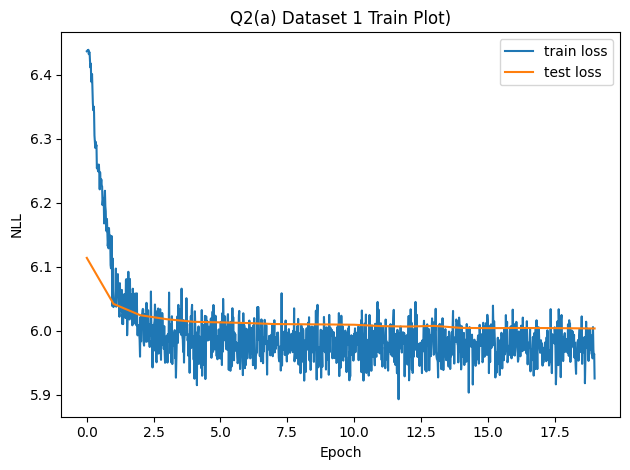

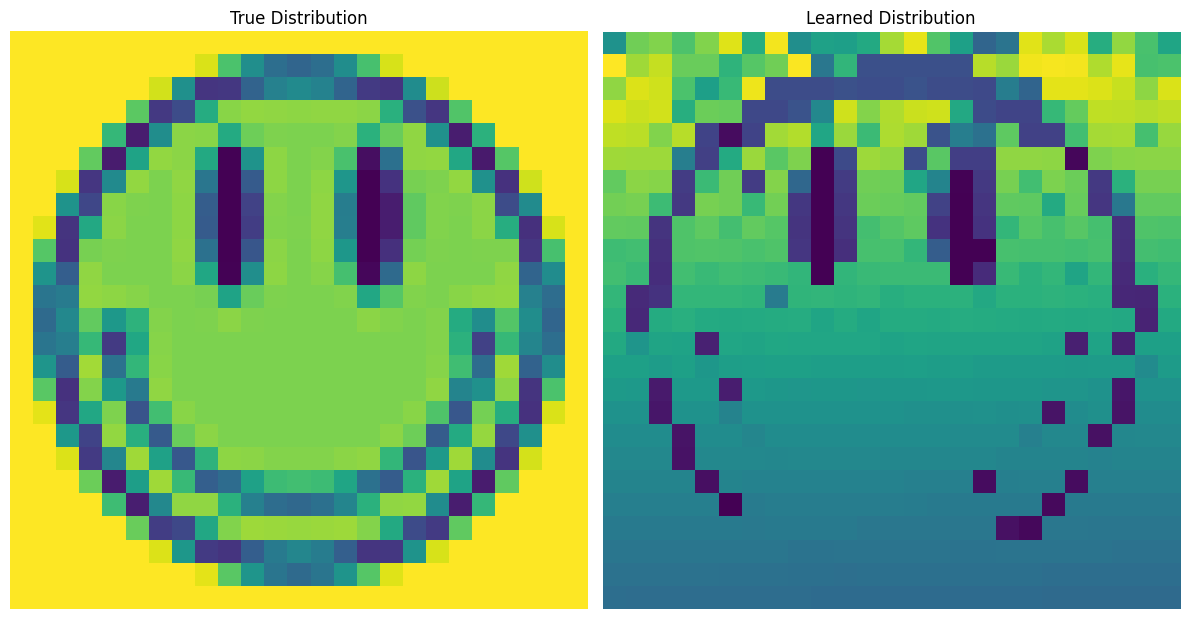

In [ ]:
q2_save_results(1, 'a', q2_a)

In [ ]:
q2_save_results(2, 'a', q2_a)

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

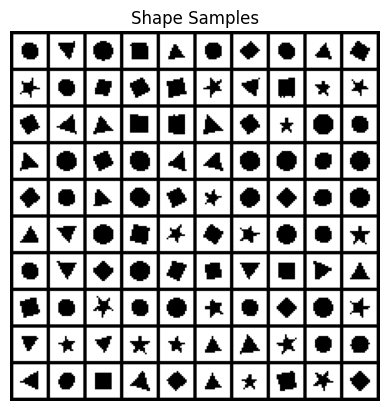

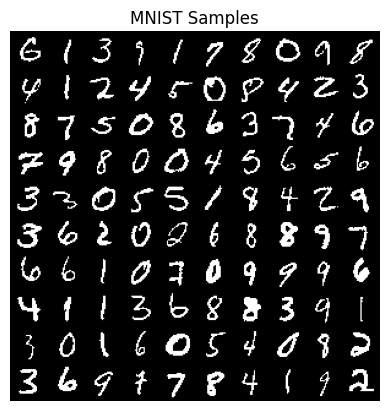

In [ ]:
visualize_q2b_data(1)
visualize_q2b_data(2)

Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q2_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  image_shape: (H, W), height and width of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """

  """ YOUR CODE HERE """

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



In [ ]:
q2_save_results(1, 'b', q2_b)

In [ ]:
q2_save_results(2, 'b', q2_b)

# Question 3 PixelCNNs

Now, you will train more powerful PixleCNN models on the shapes dataset and MNIST. In addition, we will extend to modelling colored datasets with and without channel conditioning.



## Part (a) PixelCNN on Shapes and MNIST
In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images (same as Q2(b), but with a PixelCNN).

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network.

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

tensor([[[10, 10],
         [ 2,  3]],

        [[10, 10],
         [ 2,  3]],

        [[10, 10],
         [ 2,  3]]])


In [87]:
from itertools import repeat


def create_mask(mask_type, kernel_size, in_channels=1, prev_channels=0):
  """
  Create masks for PixelCNN.
  mask_type: type B allows connection to itself, while type A does not
  kernel_size: int or tuple of int
  in_channels: input channels for filter, used to create diffrent masks for each channel
  prev_channels: allow connection from channels in [0, prev_channels)
  """
  assert mask_type == 'A' or mask_type == 'B', \
         "PixelCNN mask type should be A or B"

  if isinstance(kernel_size, int):
    kernel_size = (kernel_size, kernel_size)

  mask = torch.zeros(in_channels, kernel_size[0], kernel_size[1]) # 3D
  # fill before the center
  x, y = kernel_size[0] // 2, kernel_size[1] // 2
  mask[:, :x, :] = 1.0
  mask[:, x, :y] = 1.0
  mask[:prev_channels, x, y] = 1.0
  # fill center if it is type B
  if mask_type == 'B':
    mask[prev_channels, x, y] = 1.0

  return mask


class MaskedConv2d(nn.Conv2d):
  def __init__(self, in_channels, out_channels, kernel_size, masks, **kwargs):
    super().__init__(in_channels, out_channels, kernel_size, **kwargs)

    # weight: [Cout, Cin, H, W], mask: [Cin, H, W]
    assert all(map(lambda mask: mask.shape == self.weight.shape[1:], masks)), \
           "Kernel shapes and mask shapes mismatch"

    if not isinstance(masks, torch.Tensor):
      masks = torch.tensor(masks)
    self.group_size = out_channels / masks.shape[0] # Number of filters sharing one mask
    self.register_buffer("masks", masks)

  def forward(self, x):
    masked_weight = self.weight * self.masks.expand(self.group_size, -1, -1, -1)
    output = F.conv2d(x, masked_weight, self.bias,
                      self.stride, self.padding, self.dilation, self.groups)
    return output


class PixelResBlock(nn.Module):
  def __init__(self, num_channels, kernel_size):
    super().__init__()

    self.conv1 = nn.Sequential(
      nn.Conv2d(num_channels, num_channels // 2, 1),
      nn.ReLU()
    )
    self.conv2 = nn.Sequential(
        MaskedConv2d(num_channels // 2, num_channels // 2, kernel_size,
                     create_mask('B', kernel_size), padding=kernel_size // 2),
        nn.ReLU()
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(num_channels // 2, num_channels, 1),
        nn.ReLU()
    )

  def forward(self, x):
    inputs = x
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    return inputs + x


class PixelCNN(nn.Module):
  def __init__(self, input_shape, hidden_layers, num_filters=64, use_res=True,
               indep_channels=False, color_depth=2):
    super().__init__()

    num_channels, height, width = input_shape # [C, H, W]
    assert color_depth >= 2, "Images should have at least 2 types of colors"
    assert indep_channels or num_filters % num_channels == 0, \
           "Filters should be allocated equally for each channel"

    self.input_shape = input_shape
    self.indep_channels = indep_channels
    self.color_depth = color_depth # Color depth per channel
    self.use_res = use_res

    convA = [
      self.create_masked_conv(num_channels, num_filters, 7, 'A', padding=3),
      nn.ReLU(),
    ]

    if use_res:
      mid = [PixelResBlock(num_filters, kernel_size) for kernel_size in hidden_layers]
    else:
      mid = [
        self.create_masked_conv(num_filters, num_filters, kernel_size, 'B',
                                padding=kernel_size//2)
        for kernel_size in hidden_layers
      ]
      mid = [item for pair in zip(mid, repeat(nn.ReLU())) for item in pair]

    convB = [
      self.create_masked_conv(num_filters, num_filters, 1, 'B'),
      nn.ReLU(),
      self.create_masked_conv(num_filters, color_depth * num_channels, 1, 'B'),
      # No ReLU here!
    ]
    self.layers = nn.Sequential(*convA, *mid, *convB)

  def create_masked_conv(self, in_channels, out_channels, kernel_size,
                         mask_type, **kwargs):
    num_groups = self.input_shape[0] # Number of channels
    masks = [create_mask(mask_type, kernel_size, in_channels, k)
             for k in np.linspace(0, in_channels, num=num_groups, endpoint=False)]
    conv = MaskedConv2d(in_channels, out_channels, kernel_size, masks, **kwargs)
    return conv

  def forward(self, x):
    # x = (x.float() / (self.color_depth - 1) - 0.5) * 2 # Normalized to [-1, 1]
    batch_size = x.shape[0]
    x = self.layers(x.float()) # [N, C * D, H, W]
    return x.view(batch_size, self.color_depth, *self.input_shape) # [N, D, C, H, W]

  def loss(self, target):
    logits = self(target) # [N, D, C, H, W]
    loss = F.cross_entropy(logits, target.long()) # [N, D, C, H, W] x [N, C, H, W]
    return loss

  def sample(self, num_samples=1):
    num_channels, height, width = self.input_shape
    with torch.no_grad():
      samples = torch.zeros(num_samples, *self.input_shape).to(device)
      for h in range(height):
        for w in range(width):
          for c in range(num_channels):
            logits = self(samples)[:, :, c, h, w] # [N, D]
            probs = F.softmax(logits, dim=1) # [N, D]
            samples[:, c, h, w] = torch.multinomial(probs, 1).squeeze(-1)
    return samples.detach().cpu().numpy()


In [83]:
def q3_a(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  image_shape: (H, W), height and width of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """

  """ YOUR CODE HERE """
  hyper = {
    "num_epochs": 10,
    "batch_size": 128,
    "learning_rate": 0.001,
  }

  _, H, W, C = train_data.shape
  model = PixelCNN((C, H, W), (7,) * 5, use_res=False).to(device)

  train_data = torch.from_numpy(train_data).permute(0, 3, 1, 2) # [N, H, W, C] -> [N, C, H, W]
  test_data = torch.from_numpy(test_data).permute(0, 3, 1, 2)

  train_loader = DataLoader(
    train_data,
    batch_size=hyper["batch_size"],
    shuffle=True,
  )
  test_loader = DataLoader(
    test_data,
    batch_size=hyper["batch_size"],
  )

  train_losses, test_losses = train_epochs(model, train_loader, test_loader, hyper)
  samples = model.sample(100)
  samples = np.transpose(samples, (0, 2, 3, 1)) # [N, C, H, W] -> [N, H, W, C]

  return np.array(train_losses), np.array(test_losses), samples


### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results



In [88]:
q3a_save_results(1, q3_a)

ValueError: ignored

Epoch 0, test loss: 0.08890307694673538
Epoch 1, test loss: 0.08476109057664871
Epoch 2, test loss: 0.08283378183841705
Epoch 3, test loss: 0.08182718604803085
Epoch 4, test loss: 0.08116938173770905
Epoch 5, test loss: 0.08008229732513428
Epoch 6, test loss: 0.08037165552377701
Epoch 7, test loss: 0.07926809042692184
Epoch 8, test loss: 0.07932005077600479
Epoch 9, test loss: 0.07875675708055496
Final Test Loss: 0.0788


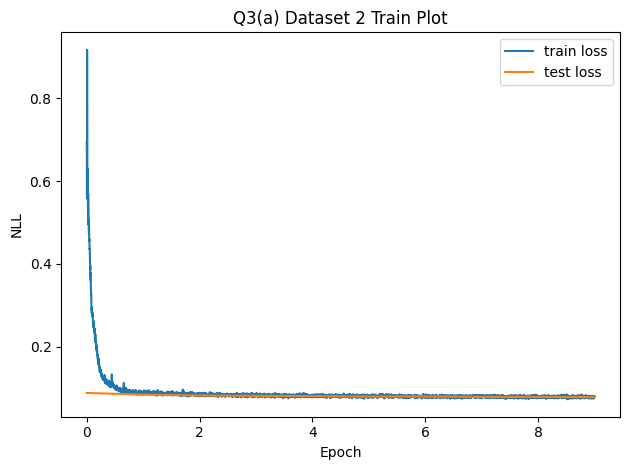

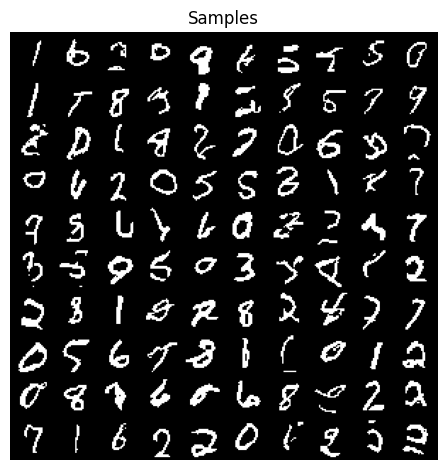

In [38]:
q3a_save_results(2, q3_a)

## Part (b) PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next two parts, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

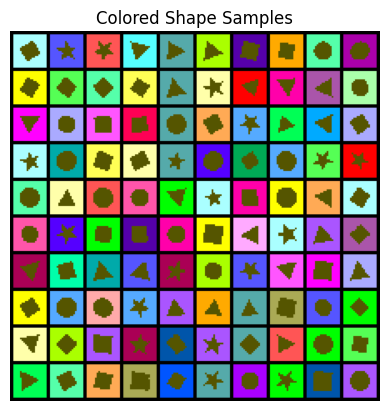

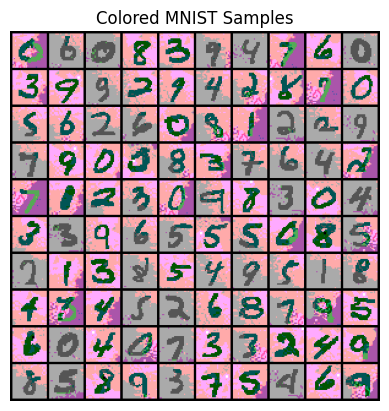

In [12]:
visualize_q3b_data(1)
visualize_q3b_data(2)

Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **First, implement a PixelCNN that assumes color channels as independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [41]:
def q3_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """

  """ YOUR CODE HERE """
  hyper = {
    "num_epochs": 15,
    "batch_size": 128,
    "learning_rate": 0.001,
  }

  _, H, W, C = train_data.shape
  model = PixelCNN((C, H, W), (7,) * 8, num_filters=120, use_res=True,
                   indep_channels=True, color_depth=4).to(device)

  train_data = torch.tensor(train_data).permute(0, 3, 1, 2) # [N, H, W, C] -> [N, C, H, W]
  test_data = torch.tensor(test_data).permute(0, 3, 1, 2)

  train_loader = DataLoader(
    train_data,
    batch_size=hyper["batch_size"],
    shuffle=True,
  )
  test_loader = DataLoader(
    test_data,
    batch_size=hyper["batch_size"],
  )

  train_losses, test_losses = train_epochs(model, train_loader, test_loader, hyper)
  samples = model.sample(100)
  samples = np.transpose(samples, (0, 2, 3, 1)) # [N, C, H, W] -> [N, H, W, C]

  return np.array(train_losses), np.array(test_losses), samples


### Results

Once you've implemented `q3_b`, execute the cells below to visualize and save your results



Epoch 0, test loss: 0.44937485456466675
Epoch 1, test loss: 0.21147696673870087
Epoch 2, test loss: 0.25853243470191956
Epoch 3, test loss: 0.11583979427814484
Epoch 4, test loss: 0.24201242625713348
Epoch 5, test loss: 0.121039018034935
Epoch 6, test loss: 0.09522978961467743
Epoch 7, test loss: 0.09481105953454971
Epoch 8, test loss: 0.08779619634151459
Epoch 9, test loss: 0.08385779708623886
Epoch 10, test loss: 0.08117521554231644
Epoch 11, test loss: 0.07914062589406967
Epoch 12, test loss: 0.07928191870450974
Epoch 13, test loss: 0.07896334677934647
Epoch 14, test loss: 0.07575401663780212
Final Test Loss: 0.0758


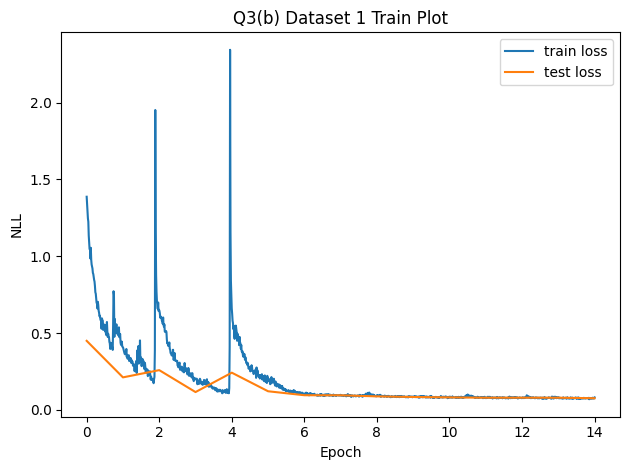

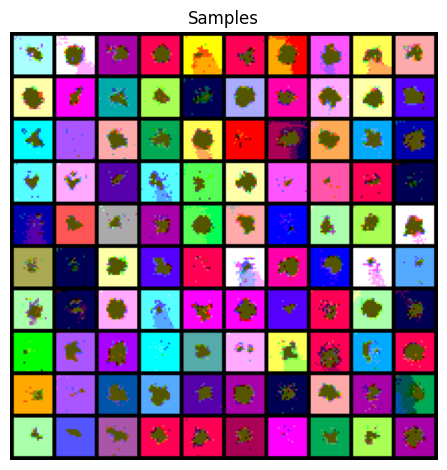

In [42]:
q3bc_save_results(1, 'b', q3_b)

In [ ]:
q3bc_save_results(2, 'b', q3_b)

## Part (c) PixelCNN on Colored Shapes and MNIST: Autoregressive Color Channels

Now, implement a PixelCNN that models **dependent** color channels. Formally, we model the parameterized distribution

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_i^{<c}, x_{<i})$$

To do so, change your masking scheme for the center pixel. Split the filters into 3 groups, only allowing each group to see the groups before (or including the current group, for type B masks) to maintain the autoregressive property.

Training times and hyperparameter settings should be the same as part (b).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q3_c(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """

  """ YOUR CODE HERE """

### Results

Once you've implemented `q3_c`, execute the cells below to visualize and save your results



In [ ]:
q3bc_save_results(1, 'c', q3_c)

In [ ]:
q3bc_save_results(2, 'c', q3_c)

## Part (d) Conditional PixelCNNs

In this part, implement and train a **class-conditional** PixelCNN on binary MNIST. Condition on a class label by adding a conditional bias in each convolutional layer. More precisely, in the $\ell$th convolutional layer, compute:
$$W_\ell * x + b_\ell + V_\ell y$$
where $W_\ell * x + b_\ell$ is a masked convolution (as in previous parts), $V$ is a 2D weight matrix, and $y$ is a one-hot encoding of the class label (where the conditional bias is broadcasted spacially and added channel-wise).

You can use a PixelCNN architecture similar to part (a). Training on the shapes dataset should be quick, and MNIST should take around 10-15 minutes


**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q3_d(train_data, train_labels, test_data, test_labels, image_shape, n_classes, dset_id):
  """
  train_data: A (n_train, H, W, 1) numpy array of binary images with values in {0, 1}
  train_labels: A (n_train,) numpy array of class labels
  test_data: A (n_test, H, W, 1) numpy array of binary images with values in {0, 1}
  test_labels: A (n_test,) numpy array of class labels
  image_shape: (H, W), height and width
  n_classes: number of classes (4 or 10)
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, C, 1) of samples with values in {0, 1}
    where an even number of images of each class are sampled with 100 total
  """

  """ YOUR CODE HERE """

### Results

Once you've implemented `q3_d`, execute the cells below to visualize and save your results



In [ ]:
q3d_save_results(1, q3_d)

In [ ]:
q3d_save_results(2, q3_d)

# Question 4: Bonus Questions (Optional)

## Part (a) Gated PixelCNN
Implement a [Gated PixelCNN](https://arxiv.org/abs/1606.05328) to fix the blind-spot issue, and report training curves, final test loss, and samples.

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q4_a(train_data, test_data, image_shape):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of generated samples with values in {0, 1, 2, 3}
  """
  """ YOUR CODE HERE """

### Results

Once you've implemented `q4_a`, execute the cells below to visualize and save your results



In [ ]:
q4a_save_results(q4_a)

## Part (b) Grayscale PixelcNN
Train a [Grayscale PixelCNN](https://arxiv.org/abs/1612.08185) on Colored MNIST. You do not need to use their architecture - stacking standard masked convolutions or residual blocks is fine. First, generate a binary image, and then the 2-bit color image.

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q4_b(train_data, test_data, image_shape):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (50, H, W, 1) of generated binary images in {0, 1}
  - a numpy array of size (50, H, W, C) of conditonally generated color images in {0, 1, 2, 3}
  """
  # You will need to generate the binary image dataset from train_data and test_data

  """ YOUR CODE HERE """

### Results

Once you've implemented `q4_b`, execute the cells below to visualize and save your results



In [ ]:
q4b_save_results(q4_b)

## Part (c) Parallel Multiscale PixelCNN
One large disadvantage of autoregressive models is their slow sampling speed, since they require one network evaluation per feature. However, there are existing methods which introduce different independence assumptions to allow for parallelism when sampling. Implement a [Parallel PixelCNN](https://arxiv.org/abs/1703.03664) on 56 x 56 MNIST images, with a base size of 7 x 7 and upscaling by a factor of 2. Sampling should be very quick (< 1s). Architectures may vary, but using small PixelCNN implementation similar to previous parts and small ResNets should suffice

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q4_c(train_data, test_data):
  """
  train_data: A (60000, 56, 56, 1) numpy array of grayscale images with values in {0, 1}
  test_data: A (10000, 56, 56, 1) numpy array of grayscale images with values in {0, 1}
  image_shape: (H, W), height and width

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 56, 56, 1) of generated samples with values in {0, 1}
  """

  """ YOUR CODE HERE """

### Results

Once you've implemented `q4_c`, execute the cells below to visualize and save your results



In [ ]:
q4c_save_results(q4_c)